In [1]:
! pip freeze | grep -E "notebook|geo|altair|matplot|seaborn|folium|geo"

altair==1.2.0
folium==0.3.0
geopandas==0.2.1
geopy==1.11.0
matplotlib==1.4.3
notebook==5.0.0
pygeocoder==1.2.5
pygeocodio==0.5.0
seaborn==0.7.1


In [59]:
import re, os
import numpy as np
import pandas as pd
from altair import Chart, load_dataset, X, Y, Color, Axis, Legend, Scale, SortField

from geocodio import GeocodioClient
# geocodio_api_key = os.getenv('GEOCODIO_API_KEY')
geocodio_api_key = '0f669aa4d57d7dab0ba9b8dd049a9957678985d'
client = GeocodioClient(geocodio_api_key)

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

In [7]:
#  dtype={'Funding': np.float64},
kyf2 = pd.read_csv('KYF2_new_compass_data_2015_geocodio_dad527759d1c56e361e09b4e110bd27d2e65a8f1.csv', na_values="No Data",
                     skipfooter=2, parse_dates=['Year'], engine='python')
print len(kyf2), 'records'
kyf2.head(2)

4185 records


,Title,Name,Abbreviati,Year,Address,State,Town,Zip,Agency,Mission_Ar,...,Census Year,State FIPS,County FIPS,Place FIPS,Census Tract Code,Census Block Code,Census Block Group,State Legislative District House,State Legislative District Senate,Congressional District
0,Alaska Cooperative Development Program,Rural Cooperative Development Grants,RCDG,2009-01-01,"Anchorage, AK",AK,Anchorage,,RBCS,Rural Development,...,2015.0,2.0,2020.0,203000.0,901.0,1015.0,1.0,State House District 20,State Senate District J,AK0
1,Alaska Cooperative Development Program,Rural Cooperative Development Grants,RCDG,2010-01-01,"Anchorage, AK",AK,Anchorage,,RBCS,Rural Development,...,2015.0,2.0,2020.0,203000.0,901.0,1015.0,1.0,State House District 20,State Senate District J,AK0


In [10]:
pd.options.display.float_format = '${:,.0f}'.format
amount = kyf2.Funding.sum()
print 'Know Your Farmer, Know Your Food \nGrants and Loans 2009–2014\n',  'TOTAL: ', amount

amount

Know Your Farmer, Know Your Food 
Grants and Loans 2009–2014
TOTAL:  574277980.457


574277980.45700002

In [11]:
pd.options.display.float_format = None

In [12]:
print '--- Count by Year ---'
print kyf2.Year.value_counts().sort_index()

print '--- Count by Funding Type ---'
print kyf2.Funding_Ty.value_counts().sort_index()



--- Count by Year ---
2009-01-01    533
2010-01-01    731
2011-01-01    778
2012-01-01    657
2013-01-01    509
2014-01-01    977
Name: Year, dtype: int64
--- Count by Funding Type ---
Grant     4059
Grants       4
Loan       121
grant        1
Name: Funding_Ty, dtype: int64


Grants vs. Loans

In [23]:
# create a new column that normalizes the funding type

# this regular expression finds "Grant", "grant" and "Grants"
grantre = re.compile('grant.?', re.IGNORECASE)


# np.where(re.match(grantre, kyf2.Funding_Ty))
# kyf2.Funding_Ty.to_replace(grantre, "Grant")


# This creates three fields, based on the original Funding Type
# 'grant_loan' is the same as Funding Type, but with consistent 'Grant' spelling.
# 'grant' is 1 if it's a grant, otherwise zero
# 'loan' is 1 if it's a loan, otherwise zero

kyf2['grant'] = np.where(kyf2.Funding_Ty.str.contains(grantre), 1,0)
kyf2['loan'] = np.where(kyf2.Funding_Ty.str.contains('Loan'), 1,0)

kyf2['grant_loan'] = np.where(kyf2.Funding_Ty.str.contains(grantre), "Grant","")
kyf2['grant_loan'] = np.where(kyf2.Funding_Ty.str.contains("Loan"), "Loan",kyf2['grant_loan'])

kyf2['grant_loan'].value_counts(dropna=False)
# kyf2[['Funding_Ty','grant_loan']].sample(12).head(12)

Grant    4064
Loan      121
Name: grant_loan, dtype: int64

In [24]:
funding_bar_data = kyf2[['Funding','Year', 'grant_loan']].copy()

# pd.set_option('display.float_format', lambda x: '$%.0f' % x)
pd.options.display.float_format = '${:,.0f}'.format
print funding_bar_data.groupby(['Year','grant_loan']).sum()

                          Funding
Year       grant_loan            
2009-01-01 Grant      $40,178,873
           Loan        $8,514,000
2010-01-01 Grant      $68,722,840
           Loan       $40,501,736
2011-01-01 Grant      $71,393,993
           Loan       $44,840,919
2012-01-01 Grant      $63,616,001
           Loan       $11,232,500
2013-01-01 Grant      $44,199,998
           Loan       $44,532,900
2014-01-01 Grant      $76,778,294
           Loan       $59,765,927


In [25]:
pd.options.display.float_format = None

In [26]:
grants_chart = Chart(funding_bar_data).mark_bar( barSize=25).encode(
    color=Color('grant_loan',
        legend=Legend(
            title='Legend',
        ),
        scale=Scale(
            domain=['Loan', 'Grant'],
            range=['salmon', '#1f77b4'],
        )
    ),
    x=X('Year:T',
        axis=Axis(
            title='Year',
        ),
        timeUnit='year',
    ),
    y='sum(Funding):Q',
).configure_cell(
    height=200,
    width=210
).configure_scale(bandSize=500)

In [27]:
grants_chart

/Users/marjorieroswell/anaconda/lib/python2.7/site-packages/altair/utils/core.py:110: FutureWarning: pandas.lib is deprecated and will be removed in a future version.
You can access infer_dtype as pandas.api.types.infer_dtype
  typ = pd.lib.infer_dtype(data)


In [28]:
grants_count_chart = Chart(funding_bar_data).mark_bar( barSize=25).encode(
    color=Color('grant_loan',
        legend=Legend(
            title='Legend',
        ),
        scale=Scale(
            domain=['Loan', 'Grant'],
            range=['salmon', '#1f77b4'],
        )
    ),
    x=X('Year:T',
        axis=Axis(
            title='Year',
        ),
        timeUnit='year',
    ),
    y='count(Funding):Q',
).configure_cell(
    height=200,
    width=210
).configure_scale(bandSize=500)

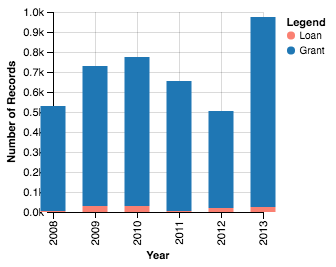

In [29]:
grants_count_chart

Chart by Grant Program

In [33]:
# Consistent spelling
incorrect_spellings =['Small and Socially Disadvantaged Producer Grants', 'Small Socially Disadvantaged Producer Grants']
correct_spellings = ['Small, Socially Disadvantaged Producer Grants', 'Small, Socially Disadvantaged Producer Grants']
corrections = pd.Series(data=correct_spellings, index=incorrect_spellings)

kyf2.replace(corrections, inplace=True)
# kyf2[kyf2.Name.str.startswith('Small,')]


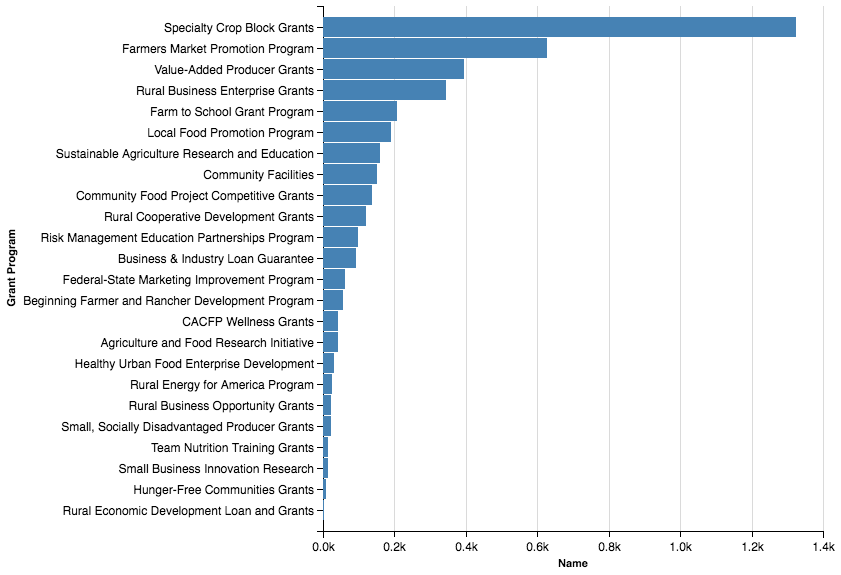

In [34]:
grantor = pd.DataFrame(kyf2['Name'].value_counts())
grantor.reset_index(inplace=True)
Chart(grantor).mark_bar() \
.encode(y=Y('index:N', sort=SortField(field='Name', order='ascending'),
        axis=Axis(title='Grant Program')), x='Name:Q') \
.configure_axis(tickLabelFontSize=12, labelMaxLength=300)

Chart Categories

In [42]:
described = kyf2.describe()
# get category counts
counts = described.iloc[0:1,3:15]
counts[counts.columns] = counts[counts.columns].astype(int)
count_df = counts.T.sort_values('count')
count_df.reset_index(inplace=True)



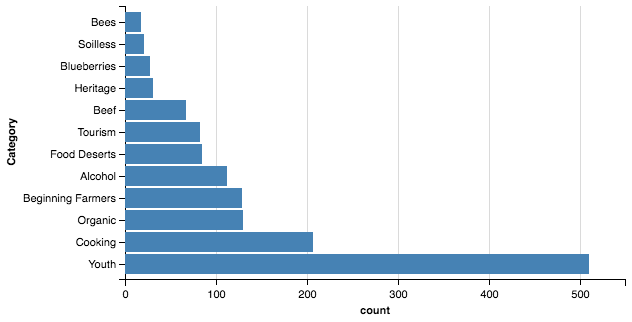

In [43]:
# unsorted version: Chart(count_df).mark_bar().encode(y='index', x='count')

Chart(count_df).mark_bar().encode(y=Y('index:N', sort=SortField(field='count', order='ascending', op='sum'),
        axis=Axis(title='Category')), x='count')
   


In [44]:
# convert categories to boolean values
bool_columns = ['Cooking','Tourism','Food Deserts','Beef','Alcohol','Bees','Youth',
                'Beginning Farmers','Organic','Blueberries', 'Heritage','Soilless','Logo/Branding']
kyf2[bool_columns] = kyf2[bool_columns].fillna(value=0)
kyf2[bool_columns] = kyf2[bool_columns].astype(int)


In [48]:
# rename columns
# kyf2.rename(columns={'X': 'lon', 'Y':'lat'}, inplace=True)


Drop blank Funding values

In [46]:
# determine if Funding row has null values
print np.where(pd.isnull(kyf2.Funding)), 'zero value for funding'

# Drop the nine records with no data for Funding
kyf2 = kyf2.dropna(subset=['Funding'])


(array([1014, 1707, 1922, 2436, 2836, 2995, 3494, 3513, 3938]),) zero value for funding


In [50]:
# create a file of all the awardees that were not geocoded
lon_zero = kyf2[kyf2['longitude'].round(decimals=1)==0.0]
lon_zero.to_csv('lon_zero.csv', encoding='utf-8')
len(lon_zero)


31

In [54]:
# import the dataset of ungeocoded records
lon_zero4geocoding = pd.read_csv('lon_zero.csv', encoding='utf-8')
lon_zero4geocoding['Zip'] = lon_zero4geocoding.Zip.astype(str)
lon_zero4geocoding.head(2)

,Unnamed: 0,Title,Name,Abbreviati,Year,Address,State,Town,Zip,Agency,...,Place FIPS,Census Tract Code,Census Block Code,Census Block Group,State Legislative District House,State Legislative District Senate,Congressional District,grant,loan,grant_loan
0,156,"Healthy Eating, Healthy Living Program",Specialty Crop Block Grants,SCBG,2014-01-01,"Executive Office Building, Utulei",AS,Pago Pago,96799,AMS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,Grant
1,157,Import Substitution Initiative (Specialty Crops),Specialty Crop Block Grants,SCBG,2013-01-01,"Executive Office Building, Utulei",AS,Pago Pago,96799,AMS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,Grant


In [55]:
address_cols = ['Unnamed: 0','Address','Town','State','Zip']
df = lon_zero4geocoding[address_cols]
df.reset_index(inplace=True)
df['full_address'] =  df['Address'] \
+", " + df['Town'] + ", " \
+ df['State'] + " " \
+ df['Zip']
df


/Users/marjorieroswell/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,index,Unnamed: 0,Address,Town,State,Zip,full_address
0,0,156,"Executive Office Building, Utulei",Pago Pago,AS,96799,"Executive Office Building, Utulei, Pago Pago, ..."
1,1,157,"Executive Office Building, Utulei",Pago Pago,AS,96799,"Executive Office Building, Utulei, Pago Pago, ..."
2,2,209,"4526 N. Anway, Rd.",Marana,AZ,85753,"4526 N. Anway, Rd., Marana, AZ 85753"
3,3,578,"81223, Cotopaxi, CO",Hillside,CO,82132,"81223, Cotopaxi, CO, Hillside, CO 82132"
4,4,596,77 Main Street,Norwich,CT,63605,"77 Main Street, Norwich, CT 63605"
5,5,603,1 Congress Street,Hartford,CT,61141,"1 Congress Street, Hartford, CT 61141"
6,6,613,17 Pearl Street,Groton,CT,63405,"17 Pearl Street, Groton, CT 63405"
7,7,834,163 Diary Road,Mangilao,GU,96913,"163 Diary Road, Mangilao, GU 96913"
8,8,835,163 Dairy Road,Mangilao,GU,96913,"163 Dairy Road, Mangilao, GU 96913"
9,9,837,"1779 Army Drive, Suite 104",Tamuning,GU,96913,"1779 Army Drive, Suite 104, Tamuning, GU 96913"


In [60]:
#extract for list of index numbers for geocoding
lon_zero_list = df.iloc[:, -1].tolist()
lon_zero_list
# geocode the awardees that had a longitude of 0
geocoded = client.geocode(lon_zero_list)
geocoded


[{u'input': {u'address_components': {u'city': u'Pago Pago',
    u'country': u'US',
    u'state': u'AS',
    u'zip': u'96799'},
   u'formatted_address': u'Pago Pago, AS 96799'},
  u'results': [{u'accuracy': 0.8,
    u'accuracy_type': u'place',
    u'address_components': {u'city': u'Pago Pago',
     u'country': u'US',
     u'county': u'Eastern District',
     u'state': u'AS',
     u'zip': u'96799'},
    u'formatted_address': u'Pago Pago, AS 96799',
    u'location': {u'lat': -14.278056, u'lng': -170.7025},
    u'source': u'TIGER/Line\xae dataset from the US Census Bureau'},
   {u'accuracy': 0.6,
    u'accuracy_type': u'place',
    u'address_components': {u'city': u"Faga'itua",
     u'country': u'US',
     u'county': u'Eastern District',
     u'state': u'AS',
     u'zip': u'96799'},
    u'formatted_address': u"Faga'itua, AS 96799",
    u'location': {u'lat': -14.271944, u'lng': -170.611944},
    u'source': u'TIGER/Line\xae dataset from the US Census Bureau'},
   {u'accuracy': 0.6,
    u'acc

In [61]:
# Create a DataFrame of latitudes and longitudes
#   in the same order as the original extracted list
awardee_geocodes = {}
counter = 0
for awardee in geocoded:
    awardee_geocodes[counter] = {}
    results = awardee.values()[1][0]
    latitude = results['location']['lat']
    longitude = results['location']['lng']
    awardee_geocodes[counter]['latitude'] = latitude
    awardee_geocodes[counter]['longitude'] = longitude
    counter +=1
awardee_geocodes
awardee_geocodes_df = pd.DataFrame(awardee_geocodes).T
awardee_geocodes_df



,latitude,longitude
0,-14.278056,-170.702500
1,-14.278056,-170.702500
2,32.287767,-111.321275
3,38.265280,-105.611670
4,41.523525,-72.086211
5,41.752879,-72.675953
6,41.325004,-71.987876
7,13.444257,144.786297
8,13.444257,144.786297
9,13.444257,144.786297


In [62]:
#append the latitude and longitude to the previously ungeocoded addresses
joined_geo_df = df.join(awardee_geocodes_df)
joined_geo_df.set_index('Unnamed: 0', inplace=True)
joined_geo_df

,index,Address,Town,State,Zip,full_address,latitude,longitude
Unnamed: 0,,,,,,,,
156,0,"Executive Office Building, Utulei",Pago Pago,AS,96799,"Executive Office Building, Utulei, Pago Pago, ...",-14.278056,-170.702500
157,1,"Executive Office Building, Utulei",Pago Pago,AS,96799,"Executive Office Building, Utulei, Pago Pago, ...",-14.278056,-170.702500
209,2,"4526 N. Anway, Rd.",Marana,AZ,85753,"4526 N. Anway, Rd., Marana, AZ 85753",32.287767,-111.321275
578,3,"81223, Cotopaxi, CO",Hillside,CO,82132,"81223, Cotopaxi, CO, Hillside, CO 82132",38.265280,-105.611670
596,4,77 Main Street,Norwich,CT,63605,"77 Main Street, Norwich, CT 63605",41.523525,-72.086211
603,5,1 Congress Street,Hartford,CT,61141,"1 Congress Street, Hartford, CT 61141",41.752879,-72.675953
613,6,17 Pearl Street,Groton,CT,63405,"17 Pearl Street, Groton, CT 63405",41.325004,-71.987876
834,7,163 Diary Road,Mangilao,GU,96913,"163 Diary Road, Mangilao, GU 96913",13.444257,144.786297
835,8,163 Dairy Road,Mangilao,GU,96913,"163 Dairy Road, Mangilao, GU 96913",13.444257,144.786297


In [63]:
# Create a list of indeces for updating
to_update_list = list(joined_geo_df.index.values)

# Loop through indeces
for idx in to_update_list:
    kyf2.loc[idx, 'latitude'] = joined_geo_df.loc[idx, 'latitude']
    kyf2.loc[idx, 'longitude'] = joined_geo_df.loc[idx, 'longitude']


In [65]:
lon_zero = kyf2[kyf2['longitude']==0.0]
lon_zero

,Title,Name,Abbreviati,Year,Address,State,Town,Zip,Agency,Mission_Ar,...,Place FIPS,Census Tract Code,Census Block Code,Census Block Group,State Legislative District House,State Legislative District Senate,Congressional District,grant,loan,grant_loan


In [66]:
# display first 3 records, not including the last 16 columns
# print kyf2.sample(6).iloc[:, 12::].head(12)
# kyf2.iloc[1014:, 10:-3:].head(4)
kyf2.iloc[1474:, 2:-13:].head(2)

,Abbreviati,Year,Address,State,Town,Zip,Agency,Mission_Ar,Recipient,Recipient_,...,Longitude,Accuracy Score,Accuracy Type,Number,Street,City,State.1,County,Zip.1,Country
1475,LFPP,2014-01-01,22 Jordan Rd.,MA,South Dartmouth,27481,AMS,Marketing and Regulatory Programs,Southeastern Massachusetts Livestock Associati...,Nonprofit,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1476,LFPP,2014-01-01,2 Washington Square,MA,Worcester,16044,AMS,Marketing and Regulatory Programs,Central Massachusetts Regional Planning Commis...,Nonprofit,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
kyf2.dtypes

Title                        object
Name                         object
Abbreviati                   object
Year                 datetime64[ns]
Address                      object
State                        object
Town                         object
Zip                          object
Agency                       object
Mission_Ar                   object
Recipient                    object
Recipient_                   object
Funding                     float64
Funding_Ty                   object
Description                  object
Topic_A                      object
Topic_B                      object
Topic_C                      object
More_infor                   object
lon                         float64
lat                         float64
Cooking                       int64
Tourism                       int64
Food Deserts                  int64
Beef                          int64
Alcohol                       int64
Bees                          int64
Youth                       

In [67]:
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '${:,.2f}'.format
print pd.DataFrame(kyf2.groupby(['grant_loan']).Funding.median()) \
.join(pd.DataFrame(kyf2.grant_loan.value_counts()))

               Funding  grant_loan
grant_loan                        
Grant       $50,000.00        4058
Loan       $815,174.50         118


In [68]:
pd.options.display.float_format = None

1.4.3


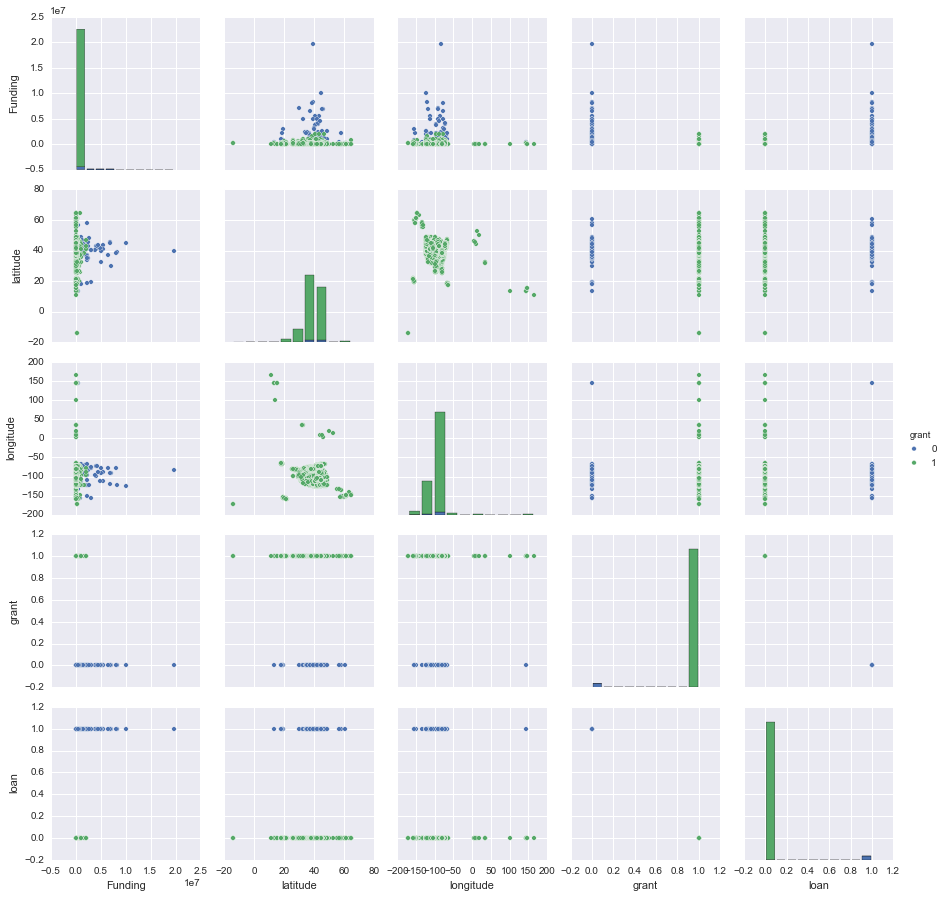

In [70]:
print matplotlib.__version__
pair_data_cols = ['Funding', 'latitude', 'longitude','grant','loan','Year']
kyf2_nums = kyf2[pair_data_cols]
# sns.pairplot(kyf2.iloc[:, :-14:], hue='grant_loan')

sns.pairplot(kyf2_nums, hue='grant')
# kyf2_nums

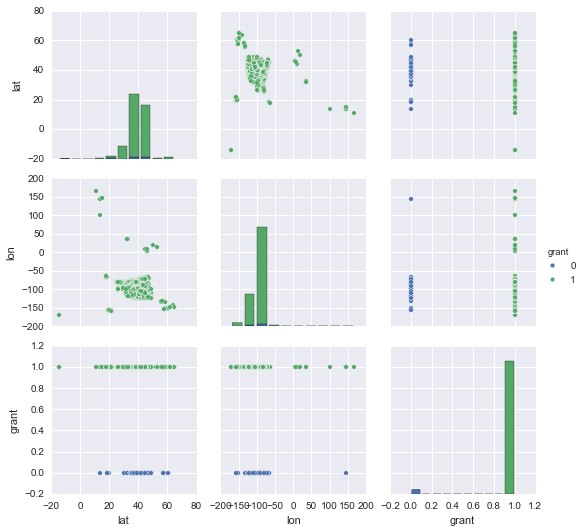

In [49]:
pair_data_cols = ['lat', 'lon', 'grant']
kyf2_nums = kyf2[pair_data_cols]
# sns.pairplot(kyf2.iloc[:, :-14:], hue='grant_loan')

sns.pairplot(kyf2_nums, hue='grant')

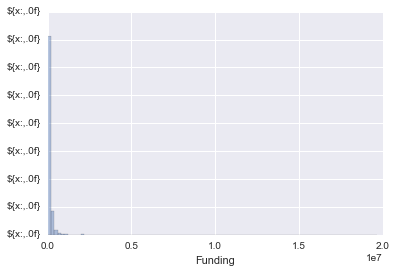

In [50]:
# # sns.plt.ticklabel_format(style='plain', axis='both',useOffset=False)
# from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
# # ax = plt.gca()
# fig, ax = plt.subplots(1, 1)

# # ax.xaxis.set_major_formatter(FormatStrFormatter('$%0.2f'))
# fmt = '${x:,.0f}'
# # tick = StrMethodFormatter(fmt)
# ax.xaxis.set_major_formatter(fmt)


from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(FormatStrFormatter('${x:,.0f}'))
sns.distplot(kyf2['Funding'], kde=False, bins =100)

In [51]:
pd.options.display.float_format = None

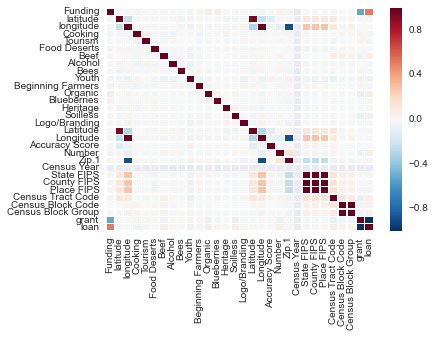

In [53]:
corr = kyf2.corr()
sns.heatmap(corr, linewidths= 0.25)